# Lab 3 - Gry dwuosobowe

In [1]:
from wsilib.algorithms.minimax.minimax import MiniMaxPlayer, MiniMaxAlphaBetaPlayer
from wsilib.game.game import TicTacToe
from wsilib.game.player import RandomPlayer

from wsilib.algorithms.evo.evo import  EvoSolver, StopConditions
from wsilib.algorithms.evo.individual import UnitRangeIndividualType

from wsilib.utils.function import Function

from typing import Tuple, Literal, List
from src.plotting import print_tic_tac_toe
from src.experiments import experiment, run_experiments
import numpy as np

from functools import cache


## Kółko i krzyżyk 3x3

### Heurystyka dla algorytmu minimax

In [2]:
def heuristic3x3(state: Tuple, turn: Literal[1, 0]) -> int:
    state = list(state)
    for i in range(len(state)):
        if state[i] is None:
            state[i] = 0
        elif state[i] == turn:
            state[i] = 1
        else:
            state[i] = -1
    matrix = np.array(state).reshape((3, 3))

    point_matrix = np.array(
        [
            [3, 2, 3],
            [2, 4, 2],
            [3, 2, 3],
        ]
    )
    return np.sum(point_matrix * matrix)

### Przykład gry MiniMax vs random


In [3]:
game = TicTacToe(size=3)

players = [
    RandomPlayer(game, 0),
    MiniMaxPlayer(game, 1, heuristic=heuristic3x3, depth=5)
]

p = 0
while True:
    print_tic_tac_toe(game.state)
    result = game.make_move(players[p].get_move())
    p = 1 - p
    if result[0]:
        print_tic_tac_toe(game.state)
        break

print("Game over. Winner:", "O" if result[1] else "X")


   |   |   
---+---+---
   |   |   
---+---+---
   |   |   


   |   |   
---+---+---
   |   |   
---+---+---
   | X |   


   | O |   
---+---+---
   |   |   
---+---+---
   | X |   


   | O |   
---+---+---
   |   |   
---+---+---
 X | X |   


   | O |   
---+---+---
   |   |   
---+---+---
 X | X | O 


   | O |   
---+---+---
   |   | X 
---+---+---
 X | X | O 


 O | O |   
---+---+---
   |   | X 
---+---+---
 X | X | O 


 O | O |   
---+---+---
   | X | X 
---+---+---
 X | X | O 


 O | O | O 
---+---+---
   | X | X 
---+---+---
 X | X | O 


Game over. Winner: O


### Performance: MiniMax vs MiniMaxAlphaBeta

In [4]:
game = TicTacToe(size=3)

minimax = MiniMaxPlayer(game, 0, heuristic=heuristic3x3, depth=5)
minimax_ab = MiniMaxAlphaBetaPlayer(game, 0, heuristic=heuristic3x3, depth=5)


import timeit
minimax_time = timeit.timeit(lambda: minimax.get_move(), number=1)
minimax_ab_tme = timeit.timeit(lambda: minimax_ab.get_move(), number=1)

print("Minimax time:", minimax_time)
print("Minimax alpha-beta time:", minimax_ab_tme)
print(f"MiniMaxAlphaBeta was {minimax_time / minimax_ab_tme:.2f} times faster than MiniMax")



Minimax time: 0.19803966600011336
Minimax alpha-beta time: 0.023782457996276207
MiniMaxAlphaBeta was 8.33 times faster than MiniMax


### Eksperyment 1: MiniMaxAlphaBeta vs Random

RandomPlayer vs MiniMaxAlphaBetaPlayer @ depth [1, 3, 5, 9]


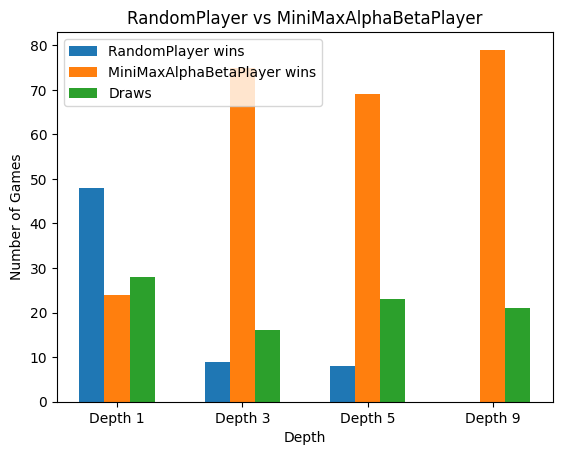

MiniMaxAlphaBetaPlayer vs RandomPlayer @ depth [1, 3, 5, 9]


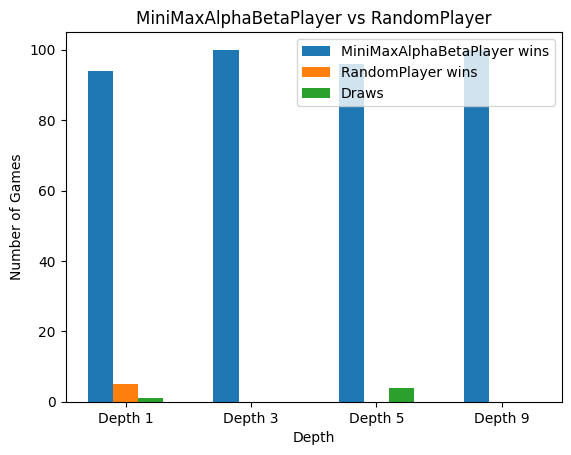

MiniMaxAlphaBetaPlayer vs MiniMaxAlphaBetaPlayer @ depth [1, 3, 5, 9]


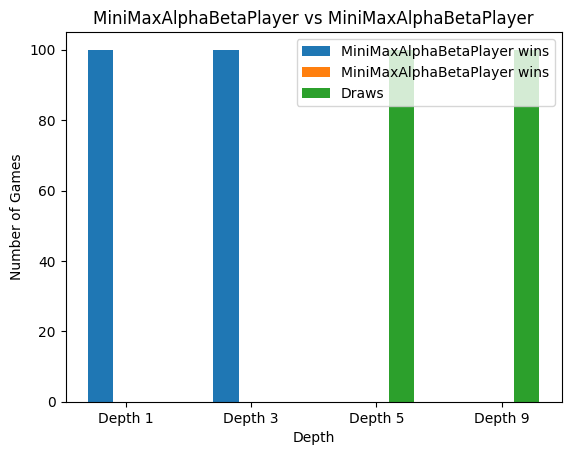

In [5]:
run_experiments(
    game=TicTacToe(size=3),
    rival_classes=[
        (RandomPlayer, MiniMaxAlphaBetaPlayer),
        (MiniMaxAlphaBetaPlayer, RandomPlayer),
        (MiniMaxAlphaBetaPlayer, MiniMaxAlphaBetaPlayer),
    ],
    depths=[1, 3, 5, 9],
    heuristic=heuristic3x3,
    num_games=100
)

## Kółko i Krzyżyk 5x5
### Trenowanie funkcji heurystycznej za pomocą algorytmu ewolucyjnego

In [6]:
def make_heuristic(x: List) -> int:
    n = int(np.sqrt(len(x)))
    point_matrix = np.array(x).reshape((n, n))
    
    def heuristic(state: Tuple, turn: Literal[1, 0]) -> int:
        state = list(state)
        for i in range(len(state)):
            if state[i] is None:
                state[i] = 0
            elif state[i] == turn:
                state[i] = 1
            else:
                state[i] = -1
        matrix = np.array(state).reshape((n, n))
        return np.sum(point_matrix * matrix)
    
    return heuristic


@cache
def loss_function(x: List) -> float:
    heuristic = make_heuristic(x)
    n = int(np.sqrt(len(x)))
    game = TicTacToe(size=n)
    random = RandomPlayer(game, 0)
    minimax_ab = MiniMaxAlphaBetaPlayer(game, 1, heuristic=heuristic, depth=3)
    player1_wins, player2_wins, draws = experiment(game, random, minimax_ab, num_games=10)
    return player1_wins + draws

def loss_function_list(x: List) -> float:
    return loss_function(tuple(x))

function = Function(loss_function_list, dim=25)



solver = EvoSolver(
    population_size=4,
    individual_type=UnitRangeIndividualType(25),
    stop_conditions=[
        StopConditions.max_iterations(10),
    ]
)

result = solver.solve(function, log=True)
heuristic5x5 = make_heuristic(result.x)

EvoIteration(n_iter=0, time_running=1.4795, x=array([0.85715029, 0.1786543 , 0.68667544, 0.3097635 , 0.27106438,
       0.94400883, 0.81541766, 0.33828086, 0.66375486, 0.79263269,
       0.06484422, 0.50339779, 0.90653521, 0.64599458, 0.26689147,
       0.33919091, 0.55116507, 0.23525536, 0.82002953, 0.52326975,
       0.38024143, 0.68144725, 0.02684754, 0.77711921, 0.82059109]), f_value=4.0)
EvoIteration(n_iter=1, time_running=9.7231, x=array([ 0.82097166,  0.5557712 ,  0.69474336,  0.21465608,  0.27617926,
       -0.05319718,  0.12466418,  0.8435647 , -0.04758341,  0.61811611,
        0.73475063,  0.93715389,  0.62644756,  0.31841062,  0.54551994,
        0.8186615 ,  0.34177597,  0.4958385 ,  0.75936787,  0.28323698,
        0.14773037,  0.12908416,  0.27783973,  0.56216872,  0.38139963]), f_value=1.0)
EvoIteration(n_iter=2, time_running=15.209, x=array([ 0.82097166,  0.5557712 ,  0.69474336,  0.21465608,  0.27617926,
       -0.05319718,  0.12466418,  0.8435647 , -0.04758341,  0.618

In [12]:
game = TicTacToe(size=5)

players = [
    RandomPlayer(game, 0),
    MiniMaxPlayer(game, 1, heuristic=heuristic5x5, depth=3)
]

p = 0
while True:
    print_tic_tac_toe(game.state)
    result = game.make_move(players[p].get_move())
    p = 1 - p
    if result[0]:
        print_tic_tac_toe(game.state)
        break

print("Game over. Winner:", "O" if result[1] else "X")

   |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   |   |   


   |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   | X |   
---+---+---+---+---
   |   |   |   |   


   |   |   |   |   
---+---+---+---+---
 O |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   | X |   
---+---+---+---+---
   |   |   |   |   


   |   |   |   |   
---+---+---+---+---
 O |   |   |   |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   | X |   
---+---+---+---+---
   |   | X |   |   


   |   |   |   |   
---+---+---+---+---
 O |   |   | O |   
---+---+---+---+---
   |   |   |   |   
---+---+---+---+---
   |   |   | X |   
---+---+---+---+---
   |   | X |   |   


   |   |   |   |   
---+---+---+---+---
 O |   |   | O |   
---+---+---+---+---
   | X |  